## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake

print(tf.__version__)


2.15.0


## 2. Load Dataset

In [2]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset"

training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

training_dataset.summary()
testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing loaded successfully.

Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training', tensors=['images', 'labels'])

 tensor      htype            shape           dtype  compression
 -------    -------          -------         -------  ------- 
 images      image     (12808, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (12808, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing', tensors=['images', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (3210, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (3210, 1)       uint16    None   


In [3]:
data_classes = list(set(sum(training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)
print("Total Number of Classes", data_classes_count)

Total Number of Classes 28


### 2.2 Create Data Pipeline

In [4]:
training_size = int(len(training_dataset.labels) * 0.8)
print("Train Data Size", training_size, "Validation Data Size", len(training_dataset.labels) - training_size)

training_dataset = training_dataset.tensorflow()
testing_dataset = testing_dataset.tensorflow()

validation_dataset = training_dataset.skip(training_size)
training_dataset = training_dataset.take(training_size)

Train Data Size 10246 Validation Data Size 2562


In [5]:
# Define a preprocessing function
def preprocess_image(args)->tuple:
  image = args['images']
  image = tf.cast(image, tf.float32)
  image = tf.math.divide(image, 255.0)

  label = args['labels']
  label = tf.cast(label, tf.int32)
  label = tf.squeeze(label)

  encoded_label = tf.one_hot(label, depth=data_classes_count)
  return (image, encoded_label)

training_dataset = training_dataset.map(preprocess_image)
validation_dataset = validation_dataset.map(preprocess_image)
testing_dataset = testing_dataset.map(preprocess_image)

# Shuffle and batch the datasets
BATCH_SIZE = 32
training_dataset = training_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
testing_dataset = testing_dataset.batch(BATCH_SIZE)

In [6]:
for images, labels in training_dataset.take(1):
  print("Training Batch images shape:", images.shape)
  print("Training Batch labels shape:", labels.shape)

for images, labels in testing_dataset.take(1):
  print("Testing Batch images shape:", images.shape)
  print("Testing Batch labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
  print("Validation Batch images shape:", images.shape)
  print("Validation Batch labels shape:", labels.shape)

Training Batch images shape: (32, 224, 224, 3)
Training Batch labels shape: (32, 28)
Testing Batch images shape: (32, 224, 224, 3)
Testing Batch labels shape: (32, 28)
Validation Batch images shape: (32, 224, 224, 3)
Validation Batch labels shape: (32, 28)


## 3. Build Model

In [23]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks
import tensorflow_hub as hub


def build_model():
    dimensions = 224
    input_layer = layers.Input(shape=(dimensions, dimensions, 3))
    feature_extractor = tf.keras.applications.mobilenet_v2.MobileNetV2(
      input_shape=(dimensions, dimensions, 3),
      include_top=False,
    )(input_layer)
    # feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    # flatten_layer = layers.Flatten()(feature_extractor)
    flatten_layer = layers.GlobalAveragePooling2D()(feature_extractor)
    hidden_layer = layers.Dense(512, activation='relu')(flatten_layer)
    predictions = layers.Dense(data_classes_count, activation='softmax')(hidden_layer)
    model = Model(inputs=input_layer, outputs=predictions)

    LEARNING_RATE = 0.0001
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
   
    return model

DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop"
VERSION_TAG = "0.2.0-46"
BUILD_MODEL = True

if BUILD_MODEL:
  model = build_model()
else:
  model = models.load_model(f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras')
  
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 512)               655872    
                                                                 
 dense_14 (Dense)            (None, 28)                14364     
                                                                 
Total params: 2928220 (11.17 MB)
Trainable params: 2894108 

## 4. Train Model

In [24]:
%%time

EPOCHS = 3
CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/{VERSION}"

checkpoint_callback = callbacks.ModelCheckpoint(filepath=CHECKPOINT_MODEL_PATH, save_weights_only=True, verbose=1)
# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[checkpoint_callback])


Epoch 1/3
    321/Unknown - 773s 2s/step - loss: 0.6431 - accuracy: 0.8176
Epoch 1: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\VERSION
321/321 [==============================] - 897s 3s/step - loss: 0.6431 - accuracy: 0.8176 - val_loss: 9.7621 - val_accuracy: 0.0316
Epoch 2/3
321/321 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9467
Epoch 2: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\VERSION
321/321 [==============================] - 610s 2s/step - loss: 0.1724 - accuracy: 0.9467 - val_loss: 10.7861 - val_accuracy: 0.0293
Epoch 3/3
321/321 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9736
Epoch 3: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\VERSION
321/321 [==============================] - 604s 2s/step - loss: 0.0859 - accuracy: 0.9736 - val_loss: 11.2255 - val_accuracy: 0.0320
CPU times: total: 1h 17min 34s
Wall time: 35min 11s


### 4.2 Training Result


initial | Training loss: 0.6431 | Validation Loss: 9.7621 || Training Accuracy: 81.76 % | Validation Accuracy: 3.16 %
 latest | Training loss: 0.0859 | Validation Loss: 11.2255 || Training Accuracy: 97.36 % | Validation Accuracy: 3.20 %


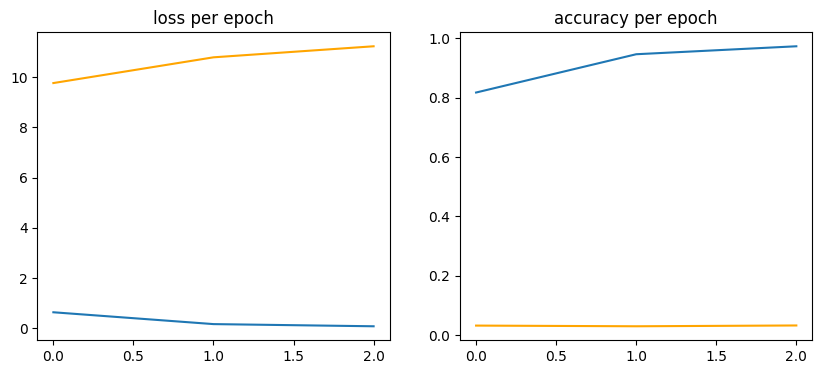

In [25]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(history.history["loss"][0], history.history["val_loss"][0], history.history["accuracy"][0] * 100, history.history["val_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(history.history["loss"][-1], history.history["val_loss"][-1], history.history["accuracy"][-1] * 100, history.history["val_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10,4)) 
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["accuracy"])
axis[1].plot(history.history["val_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

## 5. Test Model

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(testing_dataset)

print('Test loss:', test_loss, 'Test accuracy:', test_acc)

101/101 [==============================] - 36s 353ms/step - loss: 2.5552 - accuracy: 0.7240
Test loss: 2.5552103519439697 Test accuracy: 0.7239875197410583


## 6. Visualize Result

101/101 [==============================] - 39s 370ms/step


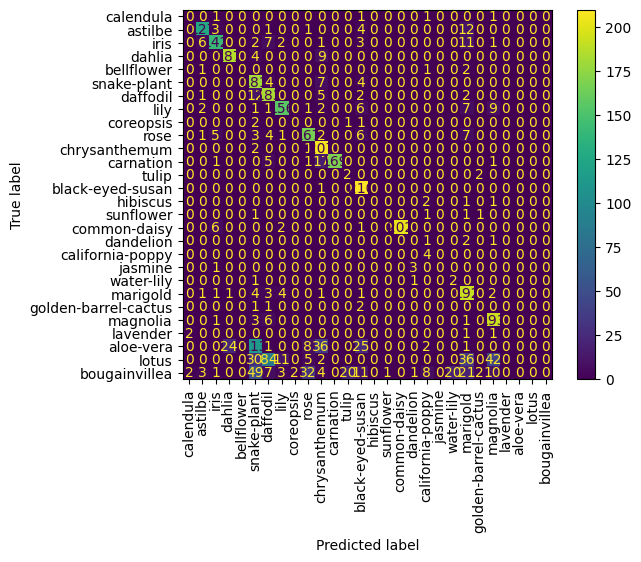

In [27]:
from sklearn import metrics

true_labels = []
for _, labels in testing_dataset:
    true_labels.extend(tf.math.argmax(labels, axis=1).numpy())

predictions = model.predict(testing_dataset)
predicted_labels = tf.math.argmax(predictions, axis=1).numpy()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=data_classes)

cm_display.plot()

# Rotate x-axis labels by 15 degrees
plt.xticks(rotation=90)
plt.show()

## 7. Save Model

In [28]:
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + f"-{int(test_acc * 100)}" if BUILD_MODEL else VERSION_TAG # "0.0.0"

models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")

C:\Users\shirs\AppData\Local\Temp\ipykernel_7628\137460559.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")
